# Exploring Sentence Processing
Let's explore using the nlp library `spaCy` for processing sentences to extract, meaning and summaries. 
For this we will use the prolouge and the first couple chapters from Saint Augustin, by Louis Bertrand from the Gutenberg project.  
[Link to Book](https://www.gutenberg.org/ebooks/9069)

In [1]:
import spacy
nlp = spacy.load("en_core_web_md")

We will read in the document as one string to then parse with spaCy.

In [2]:
file = open('saint_aug_long.txt', mode='r')
all_text = file.read()
file.close()

In [3]:
doc = nlp(all_text)

The document can be split into document spans of the sentences.

In [4]:
doc_sents = [sent for sent in doc.sents]

In [5]:
doc_sents[0].__class__

spacy.tokens.span.Span

We can treat these spans as individual documents for our purpose, although if we could make them into documents with the `Span.as_doc()` method.

In [6]:
for tok in doc_sents[3]:
    print(tok.lemma_, tok.lower_)

-PRON- our
heart heart
find finds
no no
rest rest
until until
-PRON- it
rest rests
in in
thee thee
. .
" "


   

  
_ _
Confessions confessions
_ _
, ,
-PRON- i
, ,


There are some empty sentences, we will remove these.

In [7]:
for sent in doc_sents:
    if len(sent) < 3:
        doc_sents.remove(sent)

In [8]:
len(doc_sents)

5806

### Clustering Sentences
Lets create a matrix of sentence vectors. Spacy will automatically avergage all word vectors in a sentene to create a single vector.

In [9]:
import numpy as np

In [10]:
smat = np.vstack([sent.vector for sent in doc_sents])

In [11]:
smat.shape

(5806, 300)

Now we will cluster this data. I want to test looking at the centroid of each cluster, and see if these sentences could be used as a summary of the document.

In [12]:
from sklearn.cluster import KMeans

Lets try to get the optimal number of clusters using the elbow method.

In [13]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, random_state=123)
    km = km.fit(smat)
    Sum_of_squared_distances.append(km.inertia_)

In [14]:
import matplotlib.pyplot as plt

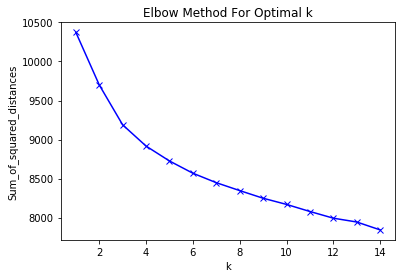

In [15]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

It is sort of ambigous, lets use 4 for now.

In [16]:
kmeans = KMeans(n_clusters=4, random_state=123)

In [17]:
sent_clusters = kmeans.fit(smat)

In [18]:
np.unique(sent_clusters.labels_, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([1545, 1401, 2725,  135]))

Now lets take the sentence closest to the centroid of each cluster.

In [19]:
from sklearn.metrics import pairwise_distances_argmin_min

In [20]:
closest, _ = pairwise_distances_argmin_min(sent_clusters.cluster_centers_, smat)

In [21]:
closest

array([5552, 2365, 5152,  174])

In theory, the centroid of these clusters, should give us a sense of the meaning of these clusters. Looking at them all together would give a simplified look at the collective meaning, or summary, of the document.

In [22]:
print('_' * 30)
for sent, clust_id in zip(np.array(doc_sents)[closest], range(4)):
    print()
    print('Cluster: ' + str(clust_id))
    print(sent)
print('_' * 30)

______________________________

Cluster: 0
Anyhow, whether he was really disgusted with the
world, or whether he deemed it prudent to throw a little oblivion over
himself just then, he spoke on all hands of resigning his post and living
in retreat like a monk.

Cluster: 1
So a chain of events, with which his will had hardly anything to do,
was going to draw the young rhetorician to Milan--yes, and how much
farther!--to where he did not want to go, to where the prayers of Monnica
summoned him unceasingly: "Where I am, there shall you be also.

Cluster: 2
For thirteen or fourteen years, through a thousand employments and a
thousand cares, amid the panics and continual alarums which kept the
Africans on the alert in those times, Augustin worked at his _City of God_,
the most formidable machine of war ever directed against paganism, and also
the arsenal fullest of proofs and refutations which the disputants and
defenders of Catholicism have ever had at their disposal.



Cluster: 3
He belo

So we would obviously need to do some more procesing of the text, and then I think this approach is not as effective on large documents like this. 

**Visualize the Data**  
We arbitrarily chose five clusters, lets take a look at the data, and see if we see any clear breaks in the information.

In [23]:
import seaborn as sns

In [24]:
from sklearn.decomposition import PCA

In [25]:
pca = PCA(n_components=2)

In [26]:
fplot = pca.fit_transform(smat)

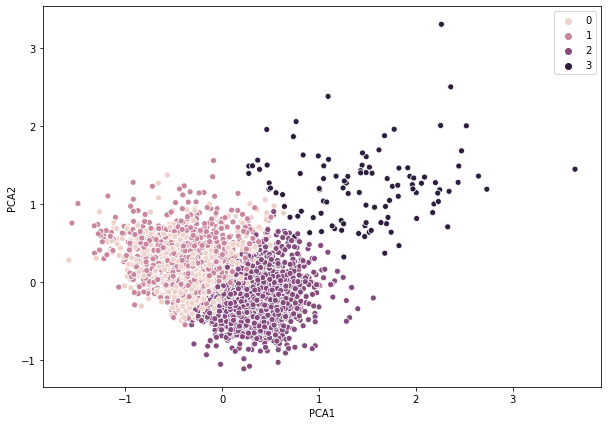

In [27]:
plt.figure(figsize=(10, 7))
plt.xlabel('PCA1')
plt.ylabel('PCA2')
p1 = sns.scatterplot(x=fplot[:,0], y=fplot[:,1],
                     hue=sent_clusters.labels_,
                     legend='full')

**Samples from Clusters**  
Let's look at the k nearest neighbors to the centroid of the clusters. This will give us a better sense of the information in each cluster.

In [28]:
from sklearn.neighbors import NearestNeighbors

In [29]:
nene = NearestNeighbors(n_neighbors=5, metric='cosine')

In [30]:
nene.fit(smat)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [31]:
n_clust = len(sent_clusters.cluster_centers_)
for centroid, clust_id in zip(sent_clusters.cluster_centers_, range(n_clust)):
    nn_a = nene.kneighbors(centroid.reshape(1, -1), 3)[1]
    print('Cluster: ' + str(clust_id))
    print("-"*30)
    for sent in np.array(doc_sents)[nn_a][0]:
        print(sent)
        print()

Cluster: 0
------------------------------
Anyhow, whether he was really disgusted with the
world, or whether he deemed it prudent to throw a little oblivion over
himself just then, he spoke on all hands of resigning his post and living
in retreat like a monk.

She began
to be sorry that she had sent him away, and with the clear-sightedness of
the Christian, she perceived that Romanianus' house was not good for the
prodigal.

If the earthly reward seemed to slip from him now, if all was sinking
around him, if his episcopal city was beleaguered, if he himself, although
still a strong man--"he had the use of all his limbs," says Possidius;


Cluster: 1
------------------------------
So a chain of events, with which his will had hardly anything to do,
was going to draw the young rhetorician to Milan--yes, and how much
farther!--to where he did not want to go, to where the prayers of Monnica
summoned him unceasingly: "Where I am, there shall you be also.

If I were to talk to you of anythin

Look like cluster 3 is mostly noise, and different languages.